In [1]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

def plot_sensitivity_by_pf_ratio(
    run_folder: str,
    fold: int,
    test_csv: str,
    sample_index: int,
    fluid_vals: list[float],
    pf_ratio_vals: list[float],
    include_ratio_features: bool = True
):
    """
    For a saved run in `run_folder`, this will:
      • Pick row `sample_index` from `test_csv` as baseline.
      • Optionally include/drop the two per‐GPI features.
      • For each propellant/fluid ratio in pf_ratio_vals:
          – Compute total_propellant = fluid * ratio for each fluid in fluid_vals
          – Predict only output1 across that sweep, for each fluid type
          – Plot Output1 vs Total Fluid (x-axis), one curve per fluid type,
            marking the actual sample point if its prop/fluid ratio matches.
    """
    # ─── Column names ─────────────────────────────────────────────────────────
    gpi_col           = "GPI (gross perforated interval ft)"
    prop_per_gpi_col  = "Proppant.per.GPI..lb.ft."
    fluid_per_gpi_col = "Fluid.per.GPI..gal.ft."
    total_prop_col    = "Total.Proppant.Volume"
    total_fluid_col   = "Total.Fluid"
    fluid_type_col    = "Fluid.Type"
    output1_col       = "BOE_Prodoction_2 year cum"

    # ─── Load hyperparams & norms ─────────────────────────────────────────────
    run_id = os.path.basename(os.path.normpath(run_folder))
    with open(os.path.join(run_folder, f"{run_id}_hyperparams.json")) as f:
        hp = json.load(f)
    with open(os.path.join(run_folder, f"{run_id}_norms.json")) as f:
        norms = json.load(f)
    layer_dims, activations = hp["layer_dims"], hp["activations"]
    y_mean = np.array(norms["y_mean"], dtype=np.float32)
    y_std  = np.array(norms["y_std"],  dtype=np.float32)
    x_mean = norms["x_mean"]
    x_std  = norms["x_std"]

    # ─── Load test data & baseline sample ────────────────────────────────────
    df = pd.read_csv(test_csv)
    sample = df.iloc[sample_index]
    sp = float(sample[total_prop_col])
    sf = float(sample[total_fluid_col])
    st = sample[fluid_type_col]
    y1_true = float(sample[output1_col])

    # compute sample’s true prop/fluid ratio and insert
    sample_pf_ratio = sp / sf
    pf_ratio_vals = sorted(set(pf_ratio_vals + [sample_pf_ratio]))

    # ─── Feature setup ────────────────────────────────────────────────────────
    numeric_feats = list(x_mean.keys())
    if not include_ratio_features:
        numeric_feats = [c for c in numeric_feats
                         if c not in (prop_per_gpi_col, fluid_per_gpi_col)]
    fluid_types = sorted(df[fluid_type_col].unique())
    dummy_feats = [f"{fluid_type_col}_{ft}" for ft in fluid_types]

    # ─── Define & load MLP ───────────────────────────────────────────────────
    class MLPNet(nn.Module):
        def __init__(self, in_dim, hidden_dims, activations, out_dim):
            super().__init__()
            layers, dims = [], [in_dim] + hidden_dims
            for i,h in enumerate(hidden_dims):
                layers.append(nn.Linear(dims[i], dims[i+1]))
                act = activations[i].lower()
                if   act=='relu':     layers.append(nn.ReLU())
                elif act=='tanh':     layers.append(nn.Tanh())
                elif act=='sigmoid':  layers.append(nn.Sigmoid())
                elif act=='softplus': layers.append(nn.Softplus())
                else: raise ValueError(f"Unknown activation '{activations[i]}'")
            layers.append(nn.Linear(dims[-1], out_dim))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLPNet(
        in_dim      = len(numeric_feats) + len(dummy_feats),
        hidden_dims = layer_dims,
        activations = activations,
        out_dim     = 2
    ).to(device)
    model.load_state_dict(torch.load(
        os.path.join(run_folder, f"{run_id}_fold{fold}.pth"),
        map_location=device
    ))
    model.eval()

    # baseline features
    base = {f: float(sample[f]) for f in numeric_feats}
    for d in dummy_feats:
        base[d] = 0.0
    gpi = float(sample[gpi_col])

    # ─── Loop over prop/fluid ratios ──────────────────────────────────────────
    for ratio in pf_ratio_vals:
        # compute total_propellant for each fluid in fluid_vals
        prop_vals = [fv * ratio for fv in fluid_vals]

        # collect output1 predictions
        preds = {ft: [] for ft in fluid_types}
        for ft in fluid_types:
            # set one-hot
            for dft in dummy_feats:
                base[dft] = 1.0 if dft==f"{fluid_type_col}_{ft}" else 0.0
            for fv, p in zip(fluid_vals, prop_vals):
                base[total_fluid_col]  = fv
                base[total_prop_col]   = p
                if include_ratio_features:
                    base[prop_per_gpi_col]  = p  / gpi
                    base[fluid_per_gpi_col] = fv / gpi
                x_vec = [(base[c]-x_mean[c])/x_std[c] for c in numeric_feats]
                x_vec += [base[d] for d in dummy_feats]
                X_in = torch.tensor([x_vec], dtype=torch.float32).to(device)
                with torch.no_grad():
                    y_n = model(X_in).cpu().numpy().flatten()
                y = y_n * y_std + y_mean
                preds[ft].append(float(y[0]))

        # ─── Plot ─────────────────────────────────────────────────────────────
        plt.figure(figsize=(8,5))
        color_map = {}
        for ft in fluid_types:
            line, = plt.plot(fluid_vals, preds[ft], label=str(ft))
            color_map[ft] = line.get_color()
        # mark actual sample if its ratio matches
        if np.isclose(ratio, sample_pf_ratio):
            plt.scatter(
                sf, y1_true,
                marker='X', s=100,
                color=color_map[st],
                edgecolor='k',
                label=f"actual (ratio={ratio:.2f})"
            )
        plt.title(f"{output1_col} vs Total Fluid  (prop/fluid={ratio:.2f})")
        plt.xlabel("Total Fluid")
        plt.ylabel(output1_col)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [2]:
fluid_vals = np.linspace(300_000, 20_000_000, num=20).tolist()
sample_index=1
pf_ratio_vals=[1,1.1,1.2,1.3,1.4]
test="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv"

# relu

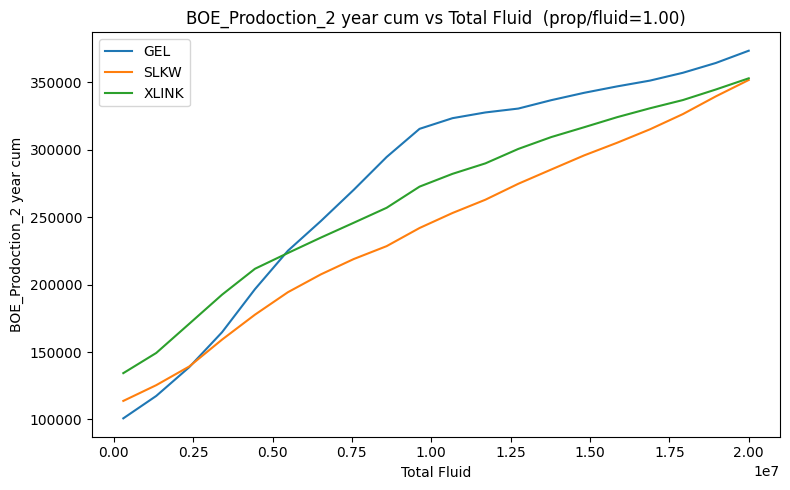

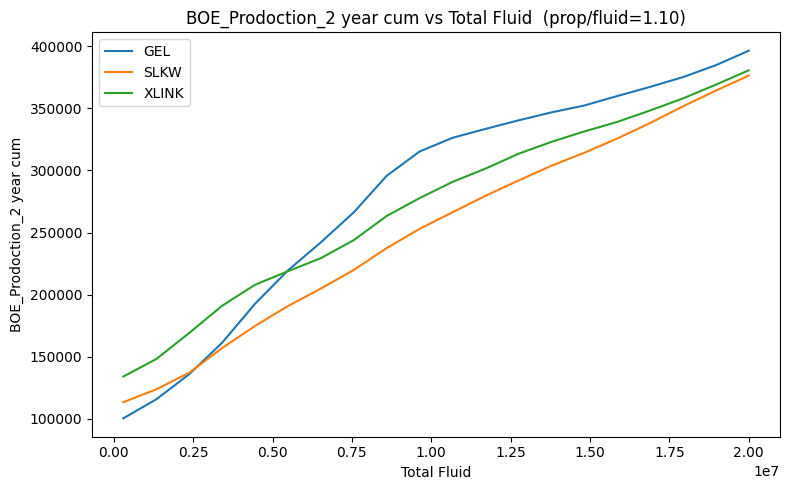

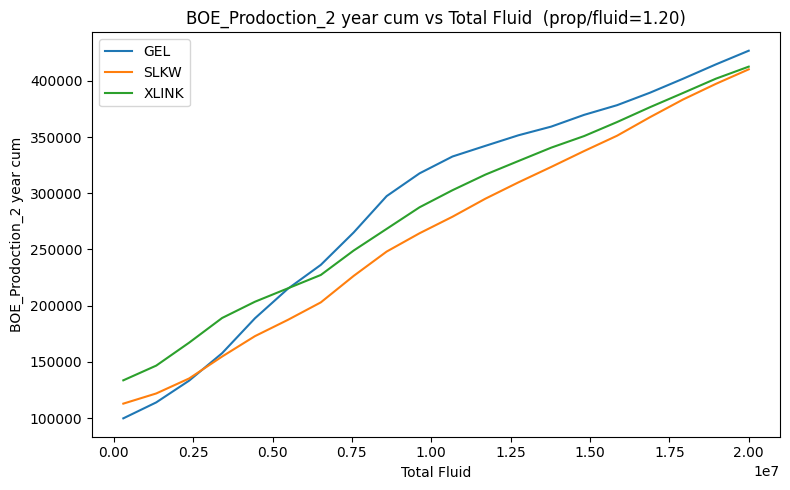

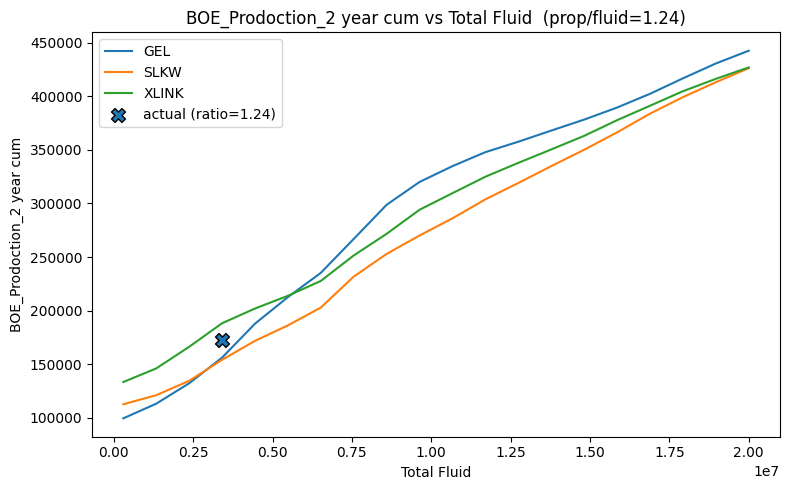

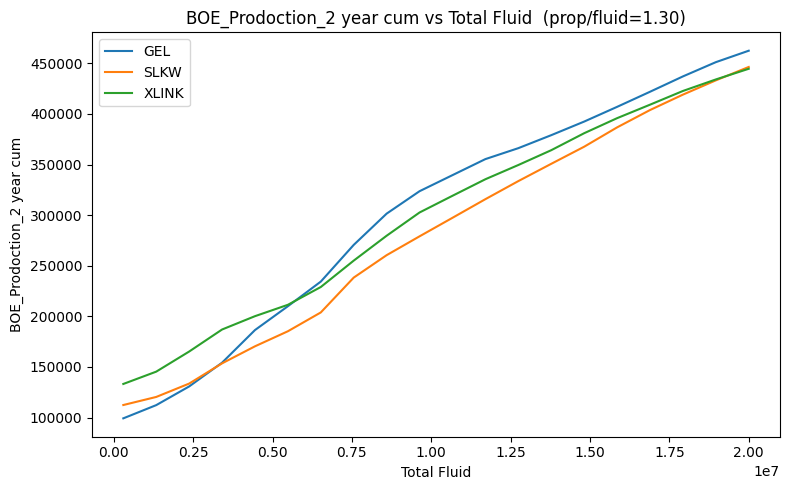

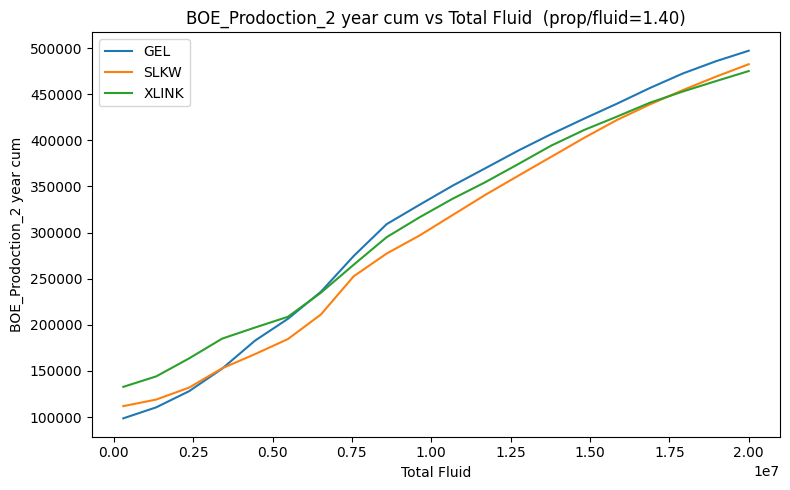

In [3]:
plot_sensitivity_by_pf_ratio(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/d3feed88",
    fold=1,
    include_ratio_features=True,
    test_csv=test,
    sample_index=sample_index,
    fluid_vals = fluid_vals,
    pf_ratio_vals=pf_ratio_vals,
)


# softplus

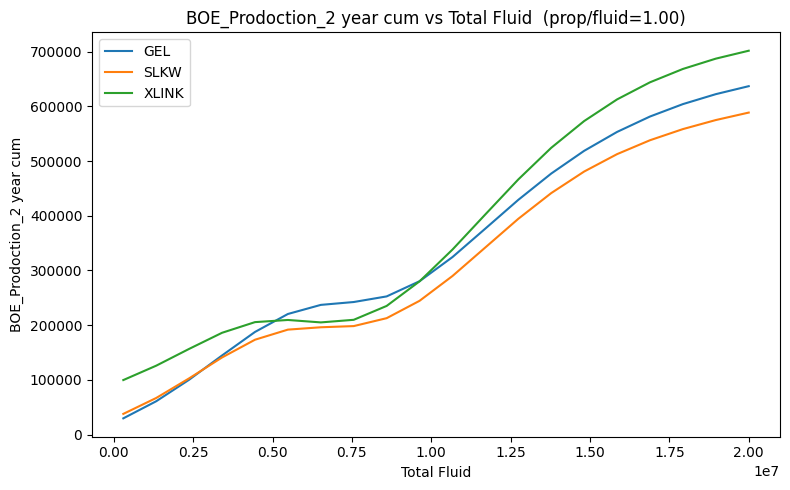

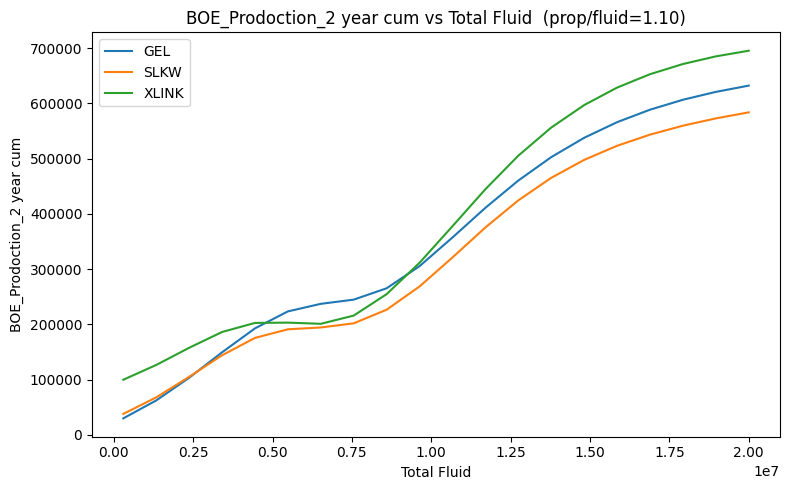

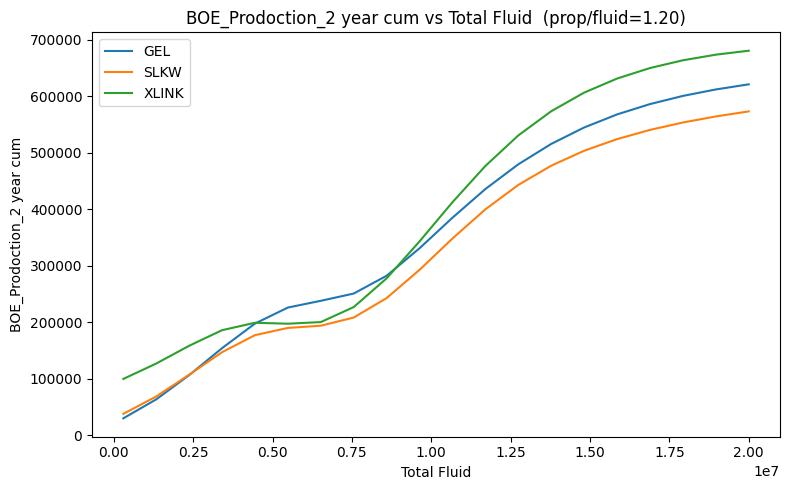

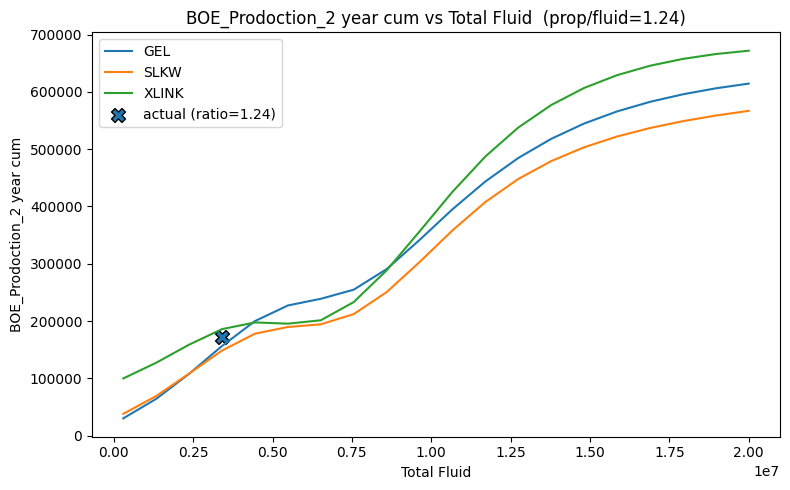

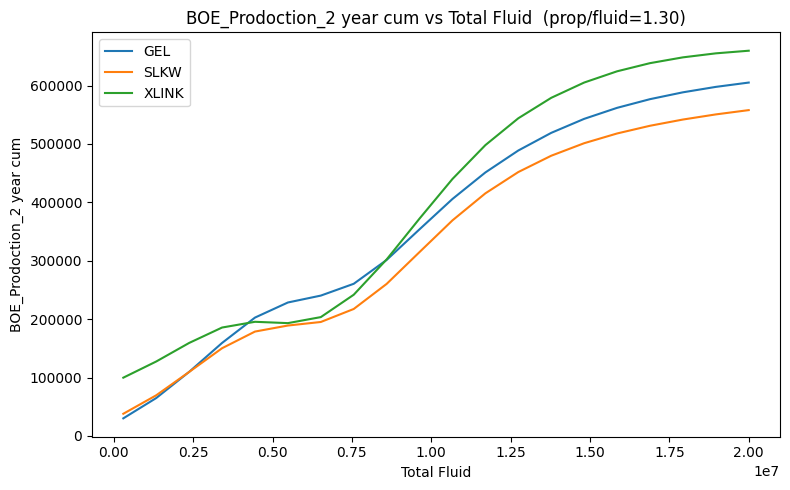

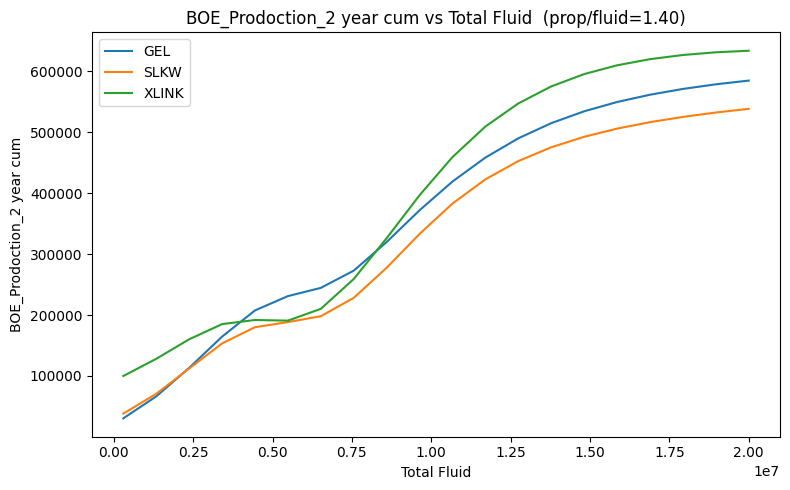

In [4]:
plot_sensitivity_by_pf_ratio(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/4eb5e823",
    fold=1,
    include_ratio_features=True,
    test_csv=test,
    sample_index=sample_index,
    fluid_vals = fluid_vals,
    pf_ratio_vals=pf_ratio_vals,
)

# relu rdundatn removed

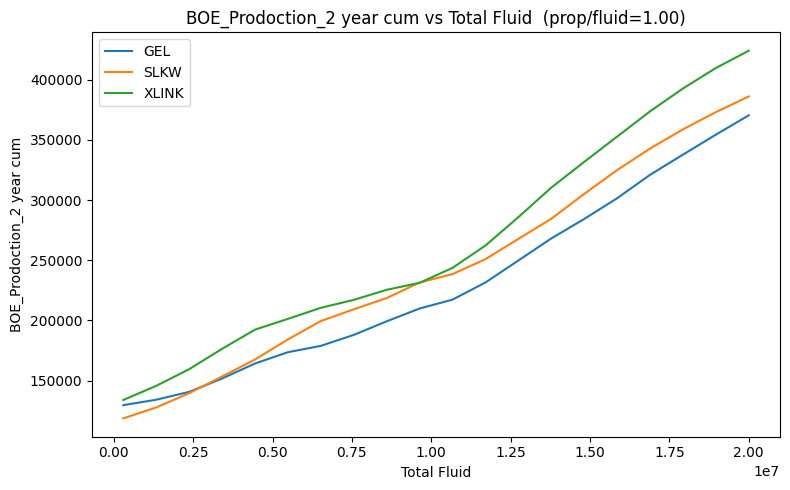

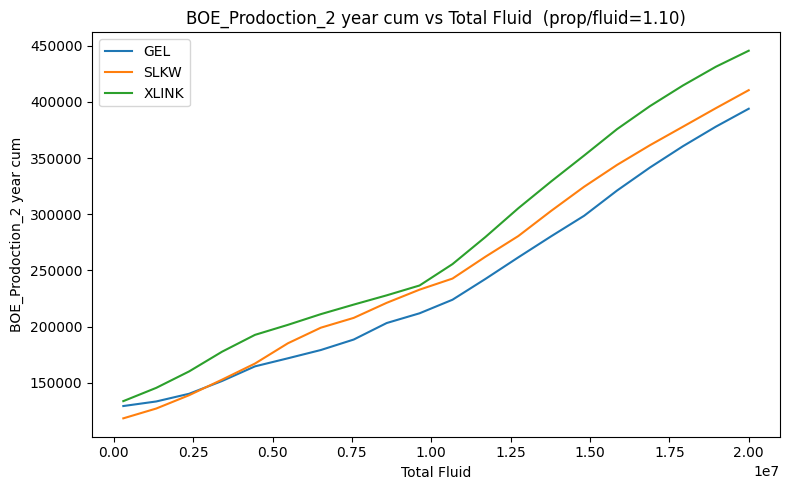

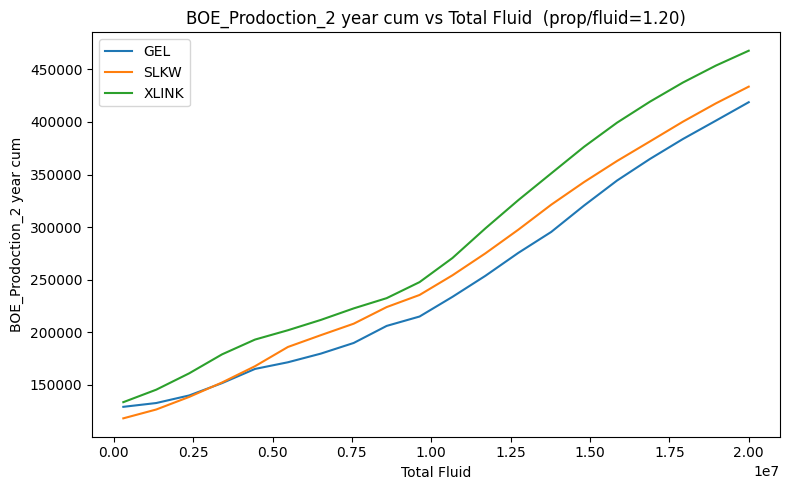

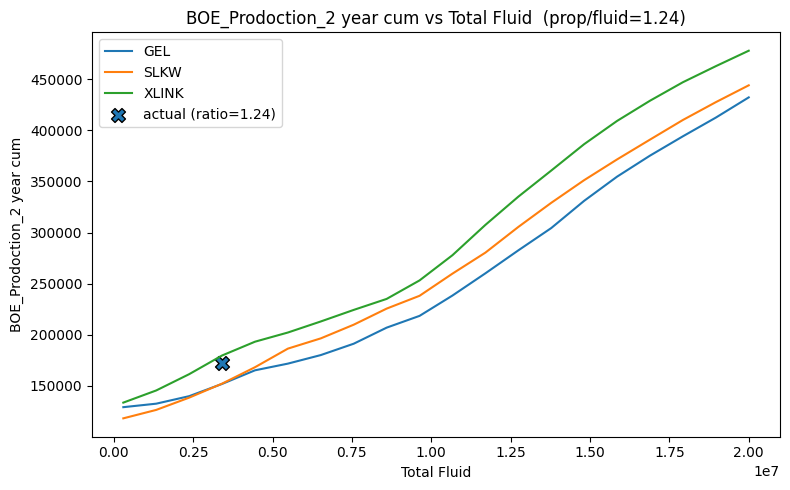

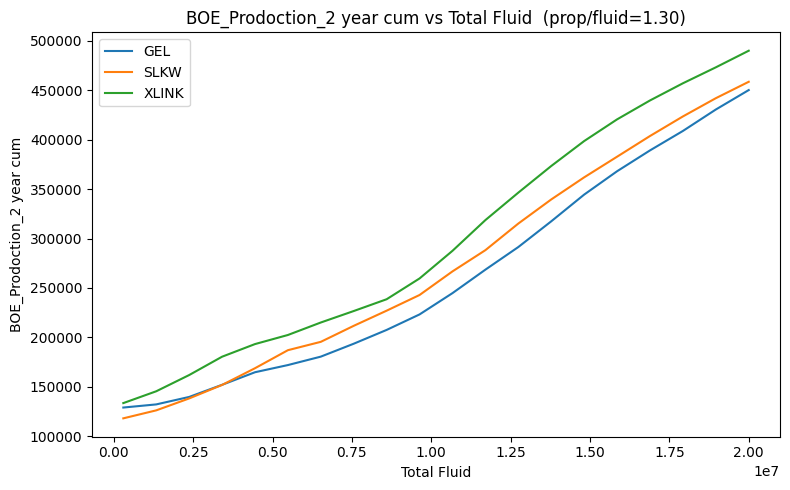

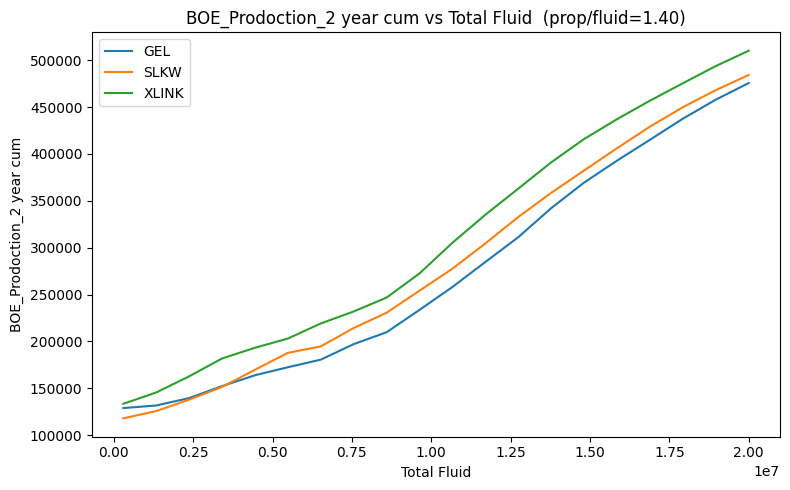

In [5]:
plot_sensitivity_by_pf_ratio(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/5044f3a3",
    fold=6,
    include_ratio_features=False,
    test_csv=test,
    sample_index=sample_index,
    fluid_vals = fluid_vals,
    pf_ratio_vals=pf_ratio_vals,
)

# redundatn removed softplus

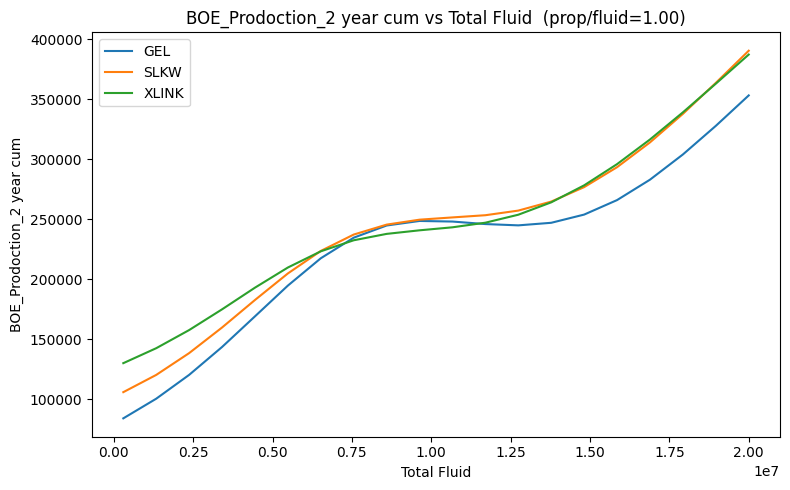

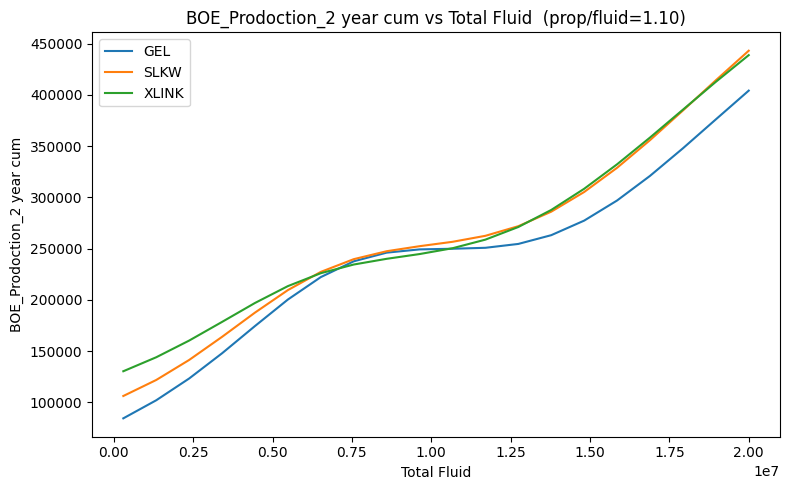

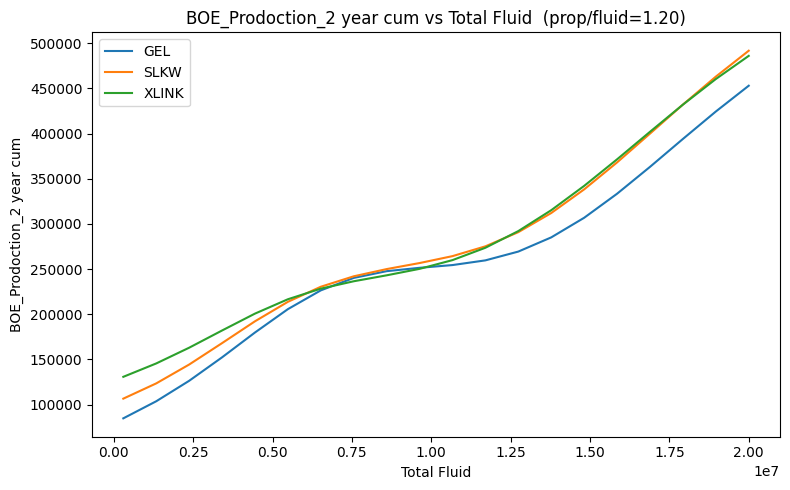

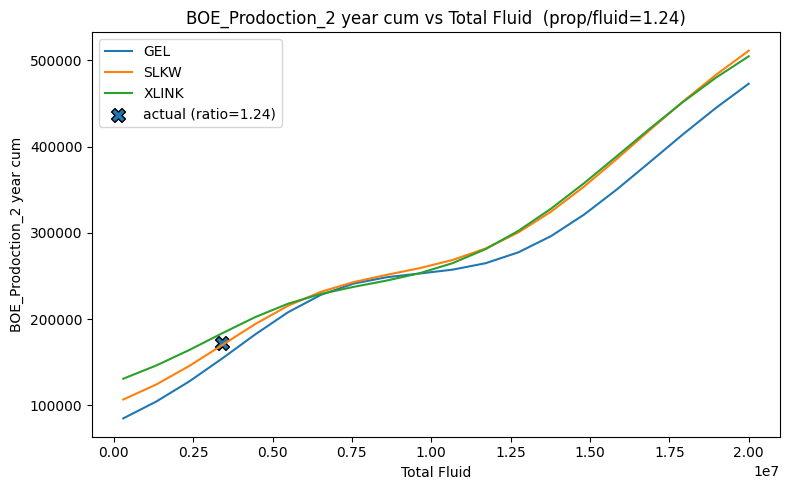

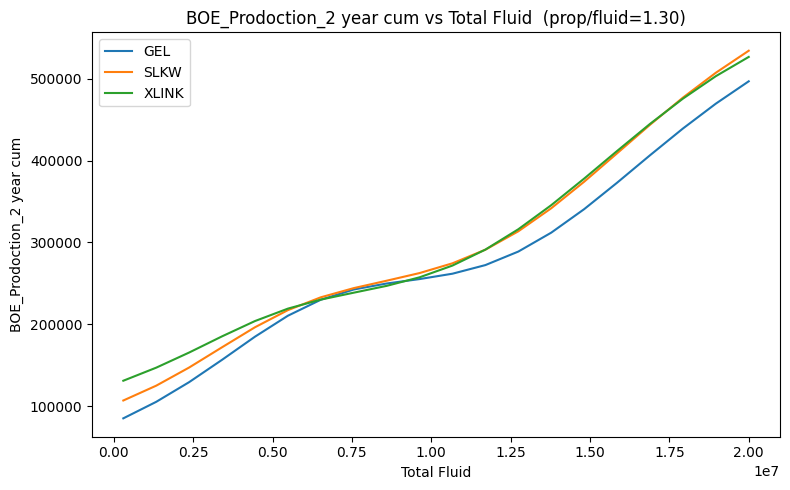

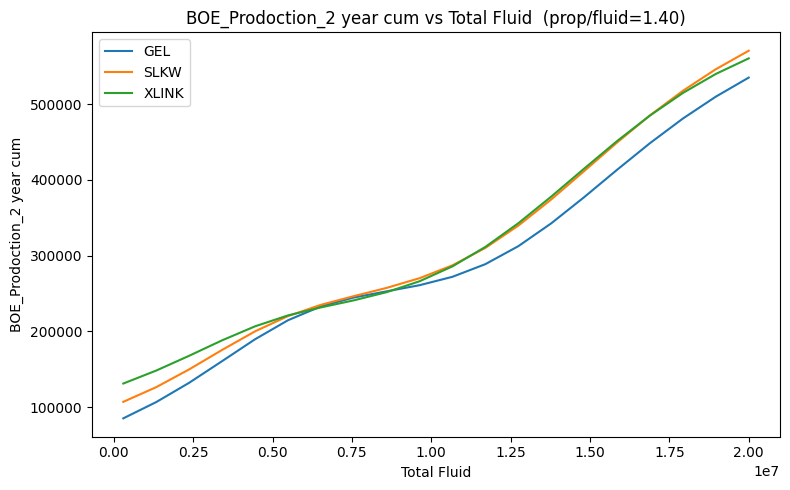

In [6]:
plot_sensitivity_by_pf_ratio(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/98a1fcb5",
    fold=6,
    include_ratio_features=False,
    test_csv=test,
    sample_index=sample_index,
    fluid_vals = fluid_vals,
    pf_ratio_vals=pf_ratio_vals,
)